#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Loading Bitcoin Dataset

In [2]:
df=pd.read_csv('Bitcoin_bitmex_final.csv',usecols=['timestamp','close'],parse_dates=True)
df.columns=['datetime','y']
df['datetime']=pd.to_datetime(df['datetime'])
df.head()

,datetime,y
0,2017-01-01 00:00:00+00:00,968.29
1,2017-01-01 01:00:00+00:00,968.00
2,2017-01-01 02:00:00+00:00,963.40
3,2017-01-01 03:00:00+00:00,964.26
4,2017-01-01 04:00:00+00:00,961.69


In [3]:
df['datetime'].freq='H'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38772 entries, 0 to 38771
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   datetime  38772 non-null  datetime64[ns, UTC]
 1   y         38772 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 605.9 KB


In [4]:
import seaborn as sns

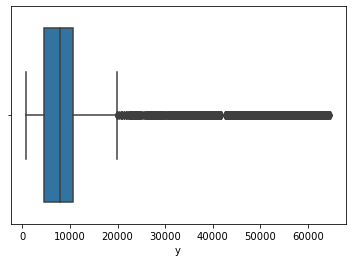

In [5]:
sns.boxplot(df['y'])

Here ,since we have many outliers so we will use Mean Absolute Error to evaluate our model.
MSE is a square of deviations and hence gives huge fluctuations to the loss function and adversely affects the convergence of SGD.But MAE ,being first order difference is less susceptible to fluctuations due to outliers.

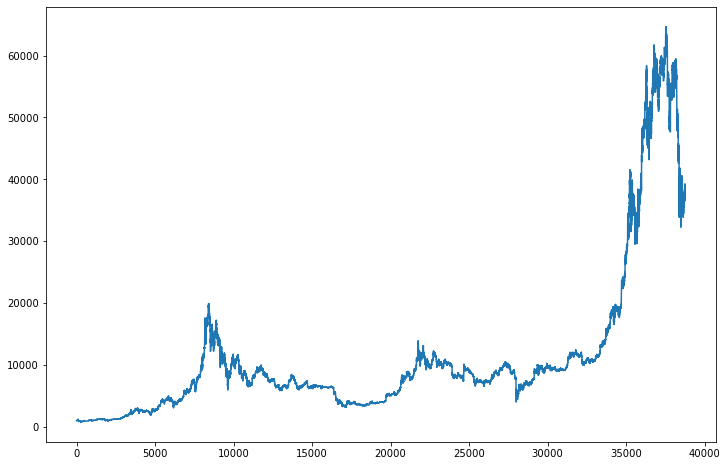

In [6]:
df['y'].plot(figsize=(12,8))

### Scaling the data using MinMax Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df['scaled_y']=scaler.fit_transform(np.array(df['y']).reshape(-1,1))

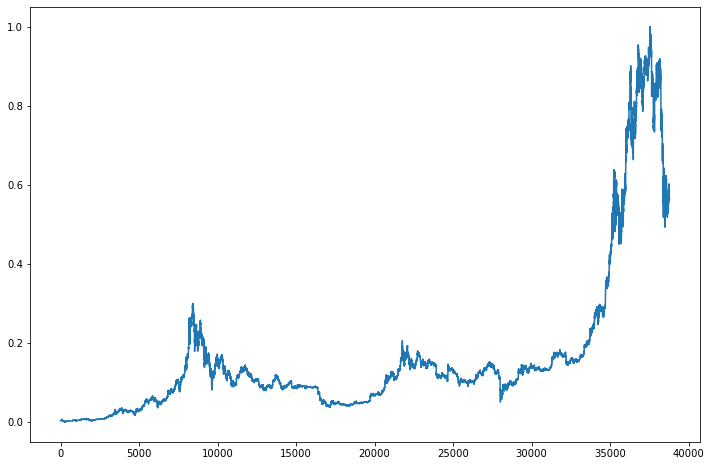

In [8]:
df['scaled_y'].plot(figsize=(12,8))

In [9]:
df[df['datetime']=="2021-03-01 00:00:00+00:00"]

,datetime,y,scaled_y
36480,2021-03-01 00:00:00+00:00,45211.0,0.695688


In [10]:
train=df.iloc[:37500]
test=df.iloc[37500:]

In [11]:
print(train.shape)
print(test.shape)

(37500, 3)
(1272, 3)


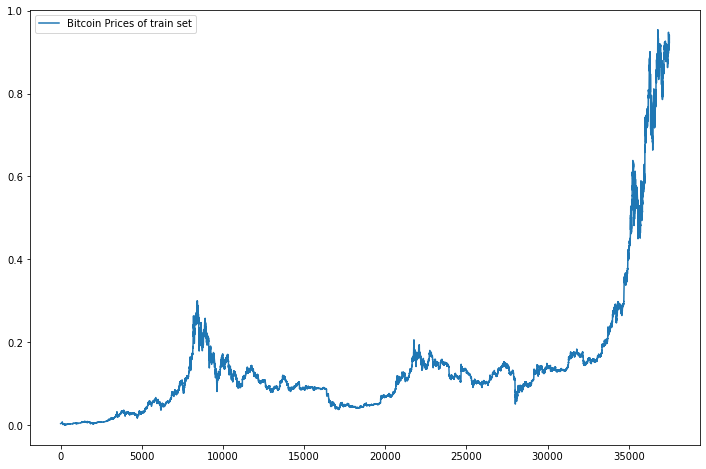

In [12]:
train['scaled_y'].plot(figsize=(12,8),label='Bitcoin Prices of train set',legend=True)

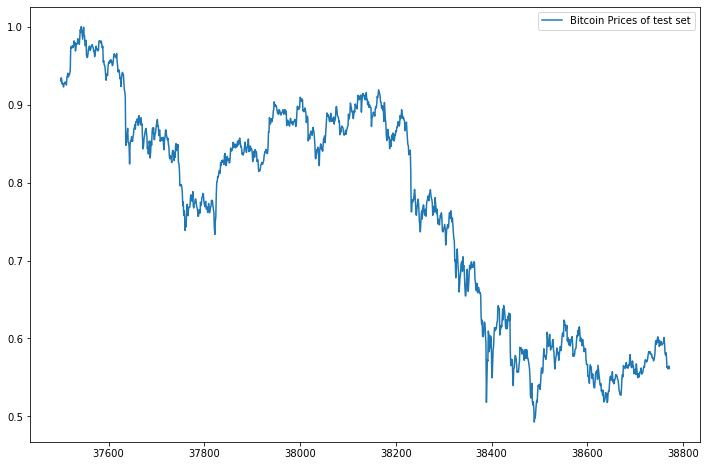

In [13]:
test['scaled_y'].plot(figsize=(12,8),label='Bitcoin Prices of test set',legend=True)

In [14]:
def makeXy(ts,nb_timesteps):
    """
    Input:
        ts:Original time series
        nb_timesteps:no. of time steps in the regressors
    Output:
        X:2-D aarray of regressors
        y:1-D array of target
    """
    X=[]
    y=[]
    for i in range(nb_timesteps,ts.shape[0]):
        X.append(list(ts.iloc[i-nb_timesteps:i]))
        y.append(ts.iloc[i])
    X,y=np.array(X),np.array(y)
    return X,y

In [15]:
X_train,y_train=makeXy(train['scaled_y'],7)
print("Shape of train arrays:",X_train.shape, y_train.shape)
X_test,y_test=makeXy(test['scaled_y'],7)
print("Shape of test arrays:",X_test.shape, y_test.shape)

Shape of train arrays: (37493, 7) (37493,)
Shape of test arrays: (1265, 7) (1265,)


In [16]:
X_train

array([[0.00350731, 0.00350278, 0.00343081, ..., 0.00340405, 0.00340875,
        0.00344755],
       [0.00350278, 0.00343081, 0.00344426, ..., 0.00340875, 0.00344755,
        0.00349918],
       [0.00343081, 0.00344426, 0.00340405, ..., 0.00344755, 0.00349918,
        0.00349495],
       ...,
       [0.92462204, 0.92211883, 0.93225684, ..., 0.93088789, 0.94129969,
        0.94045486],
       [0.92211883, 0.93225684, 0.92998048, ..., 0.94129969, 0.94045486,
        0.93879648],
       [0.93225684, 0.92998048, 0.93088789, ..., 0.94045486, 0.93879648,
        0.92771977]])

In [17]:
y_train

array([0.00349918, 0.00349495, 0.0034646 , ..., 0.93879648, 0.92771977,
       0.92323745])

In [ ]:
import keras

In [ ]:
from keras.layers import Dense,Input,Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [ ]:
input_layer=Input(shape=(7,),dtype='float32')

In [ ]:
dense1=Dense(32, activation='linear')(input_layer)
dense2=Dense(16, activation='linear')(dense1)
dense3=Dense(16, activation='linear')(dense2)

In [ ]:
dropout_layer=Dropout(0.1)(dense3)

#### Dropout Layer helps in avoiding overfitting

In [ ]:
output_layer=Dense(1,activation='linear')(dropout_layer)

In [ ]:
ts_model=Model(inputs=input_layer,outputs=output_layer)
ts_model.compile(loss='mean_absolute_error',optimizer='adam')
ts_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________

#### Here we have a dataset(train set) with 37493 samples (rows of data) and we choose a batch size of 16 and 20 epochs.

#### This means that the dataset will be divided into 37493/16 =2344 batches, each with 16 samples. The model weights will be updated after each batch of 16 samples.

#### This also means that one epoch will involve 2344 batches or 2344 updates to the model.

#### With 20 epochs, the model will be exposed to or pass through the whole dataset 20 times. That is a total of 2344*20=46880 batches during the entire training process

In [ ]:
best_model=ts_model.fit(x=X_train,y=y_train,batch_size=16,epochs=20,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/20
2344/2344 [==============================] - 5s 2ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 2/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0074 - val_loss: 0.0291
Epoch 3/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0073 - val_loss: 0.0143
Epoch 4/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0067 - val_loss: 0.0229
Epoch 5/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0068 - val_loss: 0.0296
Epoch 6/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0068 - val_loss: 0.0162
Epoch 7/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0068 - val_loss: 0.0245
Epoch 8/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0066 - val_loss: 0.0232
Epoch 9/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 10/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.006

In [ ]:
preds=ts_model.predict(X_test)

In [ ]:
preds

array([[0.91365564],
       [0.9134815 ],
       [0.9139911 ],
       ...,
       [0.55875665],
       [0.5581638 ],
       [0.5573767 ]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(y_test,preds)
print("The Mean Absolute Error is:",error)

The Mean Absolute Error is: 0.011228421282701488


In [ ]:
from sklearn.metrics import mean_squared_error
error1=mean_absolute_error(y_test,preds)
print("The Mean Squared Error is:",error1)

The Mean Squared Error is: 0.011228421282701488


In [ ]:
true_predictions=scaler.inverse_transform(preds)
true_predictions
y_test=scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
y_test=pd.Series(y_test.flatten())
predictions=pd.Series(true_predictions.flatten())

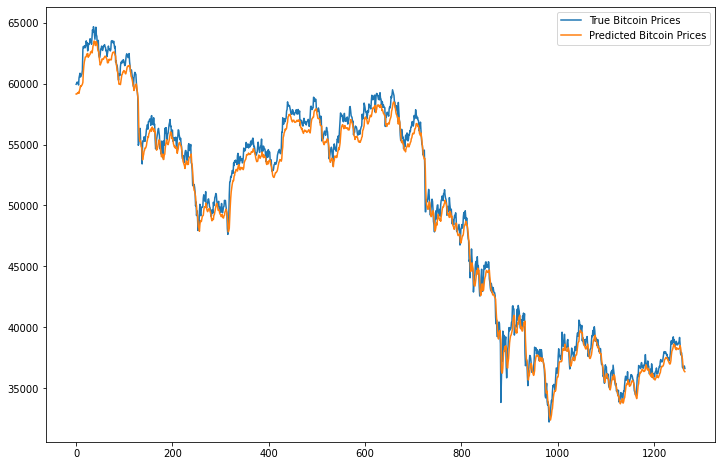

In [ ]:
y_test.plot(figsize=(12,8),label='True Bitcoin Prices',legend=True)
predictions.plot(label='Predicted Bitcoin Prices',legend=True)
